In [1]:
import gc
import sys
import time
import scipy
import obspy
import pyasdf
import datetime
import os, glob
import numpy as np
import pandas as pd
sys.path.insert(1,'/home/bxh220006/software/NoisePy/src')
import noise_module
from mpi4py import MPI
from scipy.fftpack.helper import next_fast_len
import matplotlib.pyplot  as plt


tt0=time.time()

########################################
#########PARAMETER SECTION##############
########################################

# absolute path parameters
rootpath  = '.'                                # root path for this data processing
CCFDIR    = os.path.join(rootpath,'Preproc')                                    # dir to store CC data
DATADIR   = os.path.join(rootpath,'RAW_DATA')                               # dir where noise data is located
local_data_path = os.path.join(rootpath,'*')                           # absolute dir where SAC files are stored: this para is VERY IMPORTANT and has to be RIGHT if input_fmt is not h5 for asdf!!!
locations = os.path.join(DATADIR,'station.txt')                             # station info including network,station,channel,latitude,longitude,elevation: only needed when input_fmt is not h5 for asdf

# some control parameters
input_fmt   = 'h5'                                                          # string: 'h5', 'sac','mseed' 
freq_norm   = 'no'                                                         # 'no' for no whitening, or 'rma' for running-mean average, 'phase_only' for sign-bit normalization in freq domain.
time_norm   = 'one_bit'                                                          # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain
cc_method   = 'xcorr'                                                       # 'xcorr' for pure cross correlation, 'deconv' for deconvolution; FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"
flag        = True                                                          # print intermediate variables and computing time for debugging purpose
acorr_only  = False                                                         # only perform auto-correlation 
xcorr_only  = True                                                          # only perform cross-correlation or not
ncomp       = 3                                                             # 1 or 3 component data (needed to decide whether do rotation)

# station/instrument info for input_fmt=='sac' or 'mseed'
stationxml = False                                                          # station.XML file used to remove instrument response for SAC/miniseed data
rm_resp   = 'no'                                                            # select 'no' to not remove response and use 'inv','spectrum','RESP', or 'polozeros' to remove response
respdir   = os.path.join(rootpath,'resp')                                   # directory where resp files are located (required if rm_resp is neither 'no' nor 'inv')
# read station list
if input_fmt != 'h5':
    if not os.path.isfile(locations): 
        raise ValueError('Abort! station info is needed for this script')   
    locs = pd.read_csv(locations)

# pre-processing parameters 
cc_len    = 1800                                                            # basic unit of data length for fft (sec)
step      = 450                                                             # overlapping between each cc_len (sec)
smooth_N  = 10                                                              # moving window length for time/freq domain normalization if selected (points)

# cross-correlation parameters
maxlag         = 200                                                        # lags of cross-correlation to save (sec)
substack       = True                                                       # True = smaller stacks within the time chunk. False: it will stack over inc_hours
                                                                            # for instance: substack=True, substack_len=cc_len means that you keep ALL of the correlations
                                                                            # if substack=True, substack_len=2*cc_len, then you pre-stack every 2 correlation windows.
substack_len   = cc_len                                                     # how long to stack over (for monitoring purpose): need to be multiples of cc_len
smoothspect_N  = 10                                                         # moving window length to smooth spectrum amplitude (points)

# criteria for data selection
max_over_std = 10                                                           # threahold to remove window of bad signals: set it to 10*9 if prefer not to remove them

# maximum memory allowed per core in GB
MAX_MEM = 4.0

# load useful download info if start from ASDF

dfile = os.path.join(DATADIR,'download_info.txt')
down_info = eval(open(dfile).read())
samp_freq = down_info['samp_freq']
freqmin   = down_info['freqmin']
freqmax   = down_info['freqmax']
start_date = down_info['start_date']
end_date   = down_info['end_date']
inc_hours  = down_info['inc_hours']  
ncomp      = down_info['ncomp'] 

dt = 1/samp_freq

##################################################
# we expect no parameters need to be changed below

# make a dictionary to store all variables: also for later cc
fc_para={'samp_freq':samp_freq,
         'dt':dt,
         'cc_len':cc_len,
         'step':step,
         'freqmin':freqmin,
         'freqmax':freqmax,
         'freq_norm':freq_norm,
         'time_norm':time_norm,
         'cc_method':cc_method,
         'smooth_N':smooth_N,
         'rootpath':rootpath,
         'CCFDIR':CCFDIR,
         'start_date':start_date[0],
         'end_date':end_date[0],
         'inc_hours':inc_hours,
         'substack':substack,
         'substack_len':substack_len,
         'smoothspect_N':smoothspect_N,
         'maxlag':maxlag,
         'max_over_std':max_over_std,
         'ncomp':ncomp,
         'stationxml':stationxml,
         'rm_resp':rm_resp,
         'respdir':respdir,
         'input_fmt':input_fmt}
# save fft metadata for future reference
fc_metadata  = os.path.join(CCFDIR,'fft_cc_data.txt')

In [2]:
#--------MPI---------
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

if rank == 0:
    if not os.path.isdir(CCFDIR):os.mkdir(CCFDIR)
    
    # save metadata 
    fout = open(fc_metadata,'w')
    fout.write(str(fc_para));fout.close()

    # set variables to broadcast
    if input_fmt == 'h5':
        tdir = sorted(glob.glob(os.path.join(DATADIR,'*.h5')))
    else:
        tdir = sorted(glob.glob(local_data_path))
        if len(tdir)==0: raise ValueError('No data file in %s',DATADIR)
        # get nsta by loop through all event folder
        nsta = 0
        for ii in range(len(tdir)):
            tnsta = len(glob.glob(os.path.join(tdir[ii],'*'+input_fmt)))
            if nsta<tnsta:nsta=tnsta

    nchunk = len(tdir)
    splits  = nchunk
    if nchunk==0:
        raise IOError('Abort! no available seismic files for FFT')
else:
    if input_fmt == 'h5':
        splits,tdir = [None for _ in range(2)]
    else: splits,tdir,nsta = [None for _ in range(3)]

# broadcast the variables
splits = comm.bcast(splits,root=0)
tdir  = comm.bcast(tdir,root=0)


In [3]:
def local_whiten(data, fft_para):
    delta   = fft_para['dt']
    freqmin = fft_para['freqmin']
    freqmax = fft_para['freqmax']
    smooth_N  = fft_para['smooth_N']
    freq_norm = fft_para['freq_norm']
    
    if data.ndim == 1:
        axis = 0
    elif data.ndim == 2:
        axis = 1
    Nfft = int(next_fast_len(int(data.shape[axis])))
    
    nsamp = int(1.0/delta)
    n = len(data)
    
    if n == 1:
        return data
    else: 
        frange = float(freqmax) - float(freqmin)
        nsmo = int(np.fix(min(0.01, 0.5 * (frange)) * float(n) / nsamp))
        f = np.arange(n) * nsamp / (n - 1.)
        JJ = ((f > float(freqmin)) & (f<float(freqmax))).nonzero()[0]
            
        # signal FFT
        FFTs = np.fft.fft(data)
        FFTsW = np.zeros(n) + 1j * np.zeros(n)

        # Apodization to the left with cos^2 (to smooth the discontinuities)
        smo1 = (np.cos(np.linspace(np.pi / 2, np.pi, nsmo+1))**2)
        FFTsW[JJ[0]:JJ[0]+nsmo+1] = smo1 * np.exp(1j * np.angle(FFTs[JJ[0]:JJ[0]+nsmo+1]))

        # boxcar
        FFTsW[JJ[0]+nsmo+1:JJ[-1]-nsmo] = np.ones(len(JJ) - 2 * (nsmo+1))\
        * np.exp(1j * np.angle(FFTs[JJ[0]+nsmo+1:JJ[-1]-nsmo]))

        # Apodization to the right with cos^2 (to smooth the discontinuities)
        smo2 = (np.cos(np.linspace(0., np.pi/2., nsmo+1))**2.)
        espo = np.exp(1j * np.angle(FFTs[JJ[-1]-nsmo:JJ[-1]+1]))
        FFTsW[JJ[-1]-nsmo:JJ[-1]+1] = smo2 * espo

        whitedata = 2. * np.fft.ifft(FFTsW).real
        
        

        return whitedata


def whiten_backto_time(data, fft_para):
    '''
    This function takes 1-dimensional timeseries array, transforms to frequency domain using fft,
    whitens the amplitude of the spectrum in frequency domain between *freqmin* and *freqmax*
    and returns the whitened fft.
    PARAMETERS:
    ----------------------
    data: numpy.ndarray contains the 1D time series to whiten
    fft_para: dict containing all fft_cc parameters such as
        dt: The sampling space of the `data`
        freqmin: The lower frequency bound
        freqmax: The upper frequency bound
        smooth_N: integer, it defines the half window length to smooth
        freq_norm: whitening method between 'one-bit' and 'RMA'
    RETURNS:
    ----------------------
    FFTRawSign: numpy.ndarray contains the FFT of the whitened input trace between the frequency bounds
    '''

    # load parameters
    delta   = fft_para['dt']
    freqmin = fft_para['freqmin']
    freqmax = fft_para['freqmax']
    smooth_N  = fft_para['smooth_N']
    freq_norm = fft_para['freq_norm']

    # Speed up FFT by padding to optimal size for FFTPACK
    if data.ndim == 1:
        axis = 0
    elif data.ndim == 2:
        axis = 1

    Nfft = int(next_fast_len(int(data.shape[axis])))

    Napod = 100
    Nfft = int(Nfft)
    freqVec = scipy.fftpack.fftfreq(Nfft, d=delta)[:Nfft // 2]
    J = np.where((freqVec >= freqmin) & (freqVec <= freqmax))[0]
    low = J[0] - Napod
    if low <= 0:
        low = 1

    left = J[0]
    right = J[-1]
    high = J[-1] + Napod
    if high > Nfft/2:
        high = int(Nfft//2)

    FFTRawSign = scipy.fftpack.fft(data, Nfft,axis=axis)
    # Left tapering:
    if axis == 1:
        FFTRawSign[:,0:low] *= 0
        FFTRawSign[:,low:left] = np.cos(
            np.linspace(np.pi / 2., np.pi, left - low)) ** 2 * np.exp(
            1j * np.angle(FFTRawSign[:,low:left]))
        # Pass band:
        if freq_norm == 'phase_only':
            FFTRawSign[:,left:right] = np.exp(1j * np.angle(FFTRawSign[:,left:right]))
        elif freq_norm == 'rma':
            for ii in range(data.shape[0]):
                tave = noise_module.moving_ave(np.abs(FFTRawSign[ii,left:right]),smooth_N)
                FFTRawSign[ii,left:right] = FFTRawSign[ii,left:right]/tave
        # Right tapering:
        FFTRawSign[:,right:high] = np.cos(
            np.linspace(0., np.pi / 2., high - right)) ** 2 * np.exp(
            1j * np.angle(FFTRawSign[:,right:high]))
        FFTRawSign[:,high:Nfft//2+1] *= 0

        # Hermitian symmetry (because the input is real)
        FFTRawSign[:,-(Nfft//2)+1:] = np.flip(np.conj(FFTRawSign[:,1:(Nfft//2)]),axis=axis)
    else:
        FFTRawSign[0:low] *= 0
        FFTRawSign[low:left] = np.cos(
            np.linspace(np.pi / 2., np.pi, left - low)) ** 2 * np.exp(
            1j * np.angle(FFTRawSign[low:left]))
        # Pass band:
        if freq_norm == 'phase_only':
            FFTRawSign[left:right] = np.exp(1j * np.angle(FFTRawSign[left:right]))
        elif freq_norm == 'rma':
            tave = noise_module.moving_ave(np.abs(FFTRawSign[left:right]),smooth_N)
            FFTRawSign[left:right] = FFTRawSign[left:right]/tave
        # Right tapering:
        FFTRawSign[right:high] = np.cos(
            np.linspace(0., np.pi / 2., high - right)) ** 2 * np.exp(
            1j * np.angle(FFTRawSign[right:high]))
        FFTRawSign[high:Nfft//2+1] *= 0

        # Hermitian symmetry (because the input is real)
        FFTRawSign[-(Nfft//2)+1:] = FFTRawSign[1:(Nfft//2)].conjugate()[::-1]
    idata = scipy.fftpack.ifft(FFTRawSign, Nfft,axis=axis)
    length = int(data.shape[axis])
    data[0:length-1] = np.real(idata[0:length-1])    
    return data

In [4]:
freq_norm = 'rma'
fc_para={'samp_freq':samp_freq,
         'dt':dt,
         'cc_len':cc_len,
         'step':step,
         'freqmin':freqmin,
         'freqmax':freqmax,
         'freq_norm':freq_norm,
         'time_norm':time_norm,
         'cc_method':cc_method,
         'smooth_N':smooth_N,
         'rootpath':rootpath,
         'CCFDIR':CCFDIR,
         'start_date':start_date[0],
         'end_date':end_date[0],
         'inc_hours':inc_hours,
         'substack':substack,
         'substack_len':substack_len,
         'smoothspect_N':smoothspect_N,
         'maxlag':maxlag,
         'max_over_std':max_over_std,
         'ncomp':ncomp,
         'stationxml':stationxml,
         'rm_resp':rm_resp,
         'respdir':respdir,
         'input_fmt':input_fmt}

found 2 stations in total


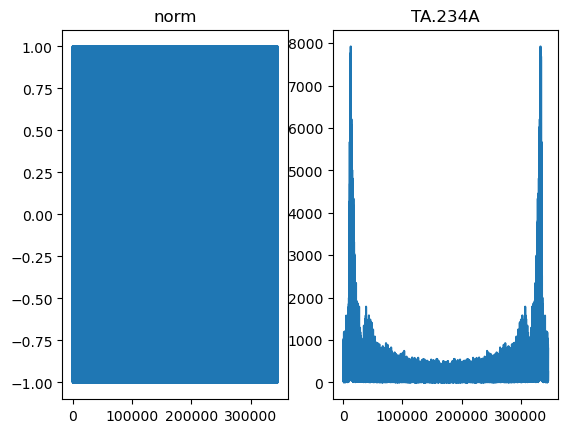

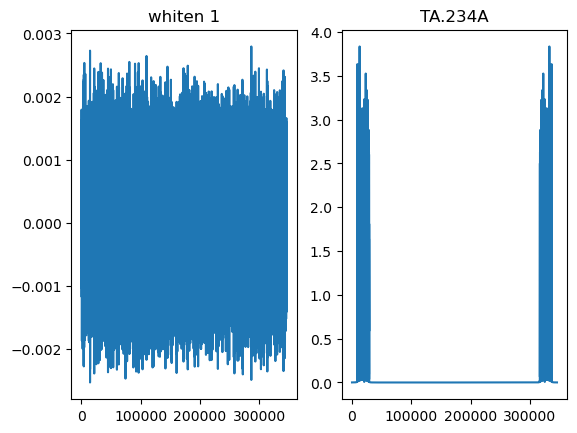

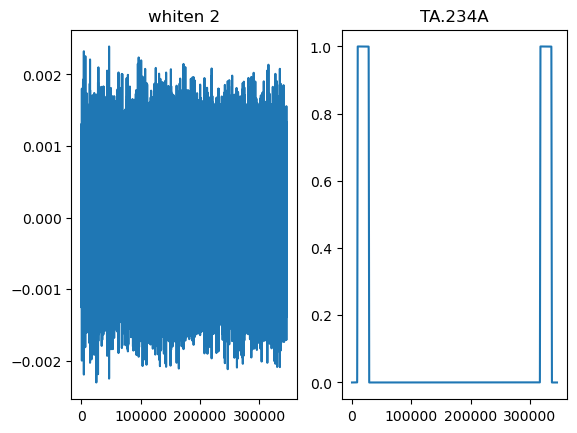

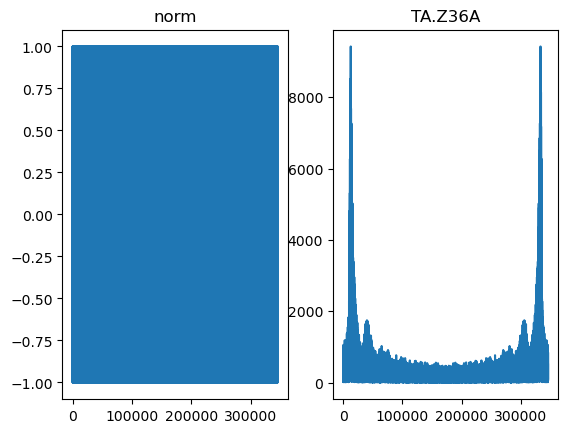

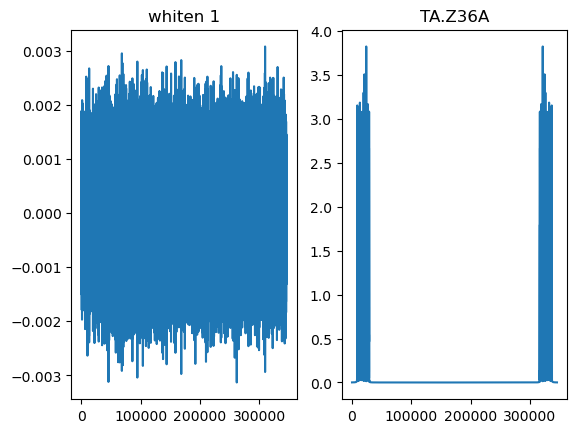

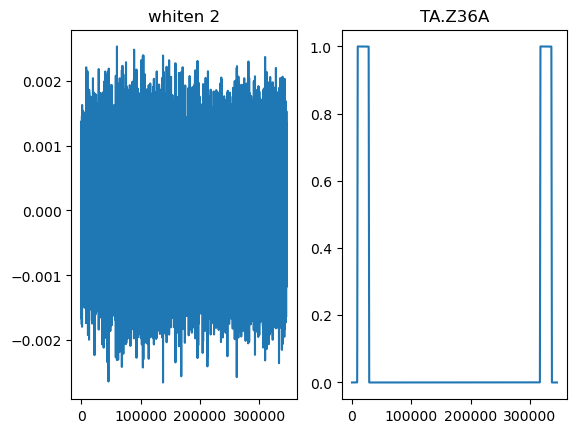

In [5]:
for ick in range (rank,splits,size):
    t10=time.time() 
    ds=pyasdf.ASDFDataSet(tdir[ick],mpi=False,mode='r') 
    sta_list = ds.waveforms.list()
    nsta=ncomp*len(sta_list)
    print('found %d stations in total'%nsta)
    for ista in range(len(sta_list)):
        tmps = sta_list[ista]
        all_tags = ds.waveforms[tmps].get_waveform_tags()
        for itag in range(len(all_tags)):
            source = ds.waveforms[tmps][all_tags[itag]]
            dataS = source[0].data
            dataS = noise_module.demean(dataS)
            dataS = noise_module.detrend(dataS)
            dataS = noise_module.taper(dataS)
            # do normalization if needed
            #------to normalize in time or not------
            N = dataS.shape[0]
            if time_norm != 'no':
                if time_norm == 'one_bit': 	# sign normalization
                    white = np.sign(dataS)
                elif time_norm == 'rma': # running mean: normalization over smoothed absolute average
                    white = np.zeros(shape=dataS.shape,dtype=dataS.dtype)
                    white[:] = dataS[:]/noise_module.moving_ave(np.abs(dataS[:]),smooth_N)
            else:# don't normalize
                white = dataS
            white = noise_module.taper(white)
            
            plt.subplot(121)
            plt.plot(white);
            plt.title('norm')
            plt.subplot(122)
            plt.plot(np.abs(np.fft.fft(white)))
            plt.title(sta_list[ista])
            plt.show()
            #-----to whiten or not------
            if freq_norm != 'no':
                whiten = whiten_backto_time(white,fc_para)	# whiten and return FFT
                whiten2 = local_whiten(white,fc_para)
            else:
                whiten = white
                whiten2 = local_whiten(white,fc_para)
            plt.subplot(121)
            plt.plot(whiten);
            plt.title('whiten 1')
            plt.subplot(122)
            plt.plot(np.abs(np.fft.fft(whiten)))
            plt.title(sta_list[ista])
            plt.show()
            
            plt.subplot(121)
            plt.plot(whiten2);
            plt.title('whiten 2')
            plt.subplot(122)
            plt.plot(np.abs(np.fft.fft(whiten2)))
            plt.title(sta_list[ista])
            plt.show()